In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Maquinas de vectores de soporte (*support vector machines*)

Método poderoso que se puede utilizar en clasificación (lineal y no-lineal), regresión, detección de anomalías, etc.

En la figura vemos datos del conjunto "Iris" que son **linealmente separables**.

A la izquierda hay límites de decisión de distintos modelos. Las líneas rojas separan bien los puntos, pero es muy probable que el error de generalización sea alto. La línea verde ni siquiera separa las clases.

A la derecha tenemos el límite de decisión de un modelo SVM. La línea separa las clases y es lo más lejos posible de los puntos.

Se puede decir que un clasificador de SVM coloca la "calle" más ancha posible entre las dos clases. Se llama clasificación de margen grande (*large margin classification*).

![](figures_svm/fig5-1.png)

El límite de decisión está determinado (soportado) solamente por las instancias en la borde de la calle. Estas instancias son los **vectores de soporte** (*support vectors*).

| ![](figures_svm/fig5-2.png) |
|-----------------------------|
| Modelos de SVM son muy sensibles al escalamiento de los *features* |

### Clasificación de margen blando (*soft margin classification*)

Si no permitimos la presencia de ninguna instancia en la "calle", y estipulamos que todas las instancias tienen que estar en su lado correcto, tenemos **clasificación de margen duro**.

Este funciona solamente si los datos son linealmente separables. Además es muy sensible a datos anómalos (*outliers*).

![](figures_svm/fig5-3.png)

Es preferible usar un modelo más flexible.

Queremos encontrar un balance entre una "calle" ancha, y un límite en el número de instancias en la "calle" (violaciones del margen, *margin violations*).

Este se llama **clasificación de margen blando**.

En los modelos de SVM en Scikit-Learn se puede controlar el número de violaciones del margen con el hiperparámetro `C`.

![](figures_svm/fig5-4.png)

In [2]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC #SVC = support vector classifier

In [3]:
iris = datasets.load_iris()

In [5]:
X = iris["data"][:, (2, 3)] #longitud pétalos, ancho pétalos
y = (iris["target"] == 2).astype(np.float64)

In [6]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [7]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

El clasificador de SVM **no** da información de las probabilidades de las clases (como el clasificador de regresión logística).

Hay otras opciones en Scikit-Learn para obtener el mismo modelo:

* `SVC(kernel="linear", C=1)` pero es mucho más lento.
* `SGDClassifier(loss="hinge", alpha=1/(m*C))` a veces es útil para datos masivos.

La clase `LinearSVC` regulariza el término del *bias*, así que hay que centrar los datos (restar el promedio). Este es automático con el uso de `StandardScaler`.

[Notar: el modelo `SGDClassifier` que usabamos en el notebook `03_clasificación` tiene `loss='hinge'` por defecto, así que estabamos usando un SVM en un espacio de 784 dimensiones...]

### Clasificación SVM no-lineal

Se puede trabajar con datos no-lineales agregando más *features*, por ejemplo *features* polinomiales (como lo que vimos antes).

| ![](figures_svm/fig5-5.png) |
|-----------------------------|
| Izquierda: datos no linealmente separables. Derecha: agregamos $x_2 = x_1^2$ para separar los datos. |

Ahora veremos un ejemplo con un conjunto de datos sintético que se llama **moons** (los datos tienen la forma de dos lunas crescientes).

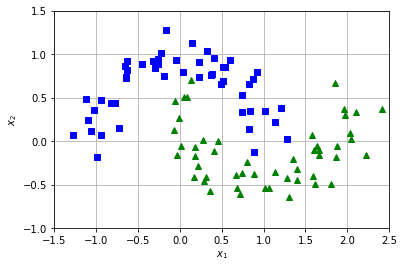

In [15]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    axis(axes)
    grid(True, which='both')
    xlabel("$x_1$")
    ylabel("$x_2$")
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

/home/graeme/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

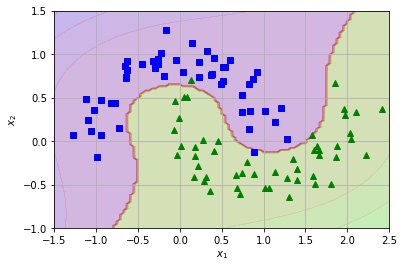

In [17]:
def plot_predictions(clf, axes):
    x0s = linspace(axes[0], axes[1], 100)
    x1s = linspace(axes[2], axes[3], 100)
    x0, x1 = meshgrid(x0s, x1s)
    X = c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    contourf(x0, x1, y_pred, cmap=cm.brg, alpha=0.2)
    contourf(x0, x1, y_decision, cmap=cm.brg, alpha=0.1)
    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

#### Núcleo polinomial (*polynomial kernel*)

Usar un polinomio de grado bajo, como lo que hicimos arriba, no funciona bien para datos complejos. Usar un polinomio de grado alto crea un número grande de *features* y el modelo es lento.

Hay un truco que se llama el **truco del núcleo** (*kernel trick*) que da el mismo resultado que antes, sin la necesidad de agregar más *features* a los datos.

In [18]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [19]:
poly10_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])

poly10_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

Text(0, 0.5, '')

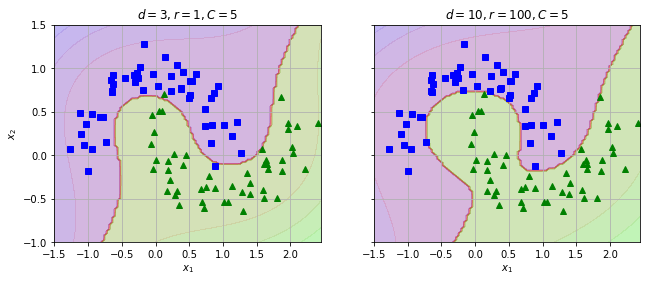

In [20]:
fig, axes = subplots(ncols=2, figsize=(10.5, 4), sharey=True)

sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
title("$d=3, r=1, C=5$")

sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
title("$d=10, r=100, C=5$")
ylabel("")

* Izquierda: clasificador de SVM con *kernel* de polinomio de grado 3.
* Derecha: con *kernel* de polinomio de grado 10.

El hiperparámetro `coef0` controla la importancia de los polinomios de grado alto versus los polinomios de grado bajo. Es un parámetro del *kernel* (más información abajo).

#### Agregando *features* de similitud (*similarity features*)

Otra técnica para datos no-lineales es el uso de más *features* calculados con una **función de similitud**.

Esta función mide la similitud entre una instancia y algún punto de referencia.

Como ejemplo, volvemos a los datos unidimensionales. Agregamos un par de puntos de referencia en $x_1 = -2$ y $x_1 = 1$.

Definimos la función de similitud como $$\phi_{\gamma}(\boldsymbol{x},\mathscr{l}) = \exp \left( -\gamma || \boldsymbol{x} - \mathscr{l} ||^2 \right)$$

Esta función se llama la **función de base radial gaussiana** (*Gaussian RBF*).

| ![](figures_svm/fig5-8.png) |
|-----------------------------|
| Gaussian RBF con $\gamma=0.3$ |

Como ejemplo, elegimos $\gamma = 0.3$. consideramos la instancia $x_1 = -1$. Tiene una distancia de $1$ del primer punto de referencia, y $2$ del segundo punto.

Entonces los nuevos *features* son $x_2 = \exp(-0.3 \times 1^2) \approx 0.74$ y $x_3 = \exp(-0.3 \times 2^2) \approx 0.30$.

En la figura arriba, a la derecha, vemos los nuevos *features* (sin el original). Los datos ahora son linealmente separables.

El uso de *similarity features* es algo que se puede aplicar a cualquier algoritmo de *machine learning* (como es el caso con *features* polinomiales).

Se puede implementar la función RBF gaussiana en un SVM usando el truco del *kernel* de nuevo (para no generar muchos *features* nuevos).

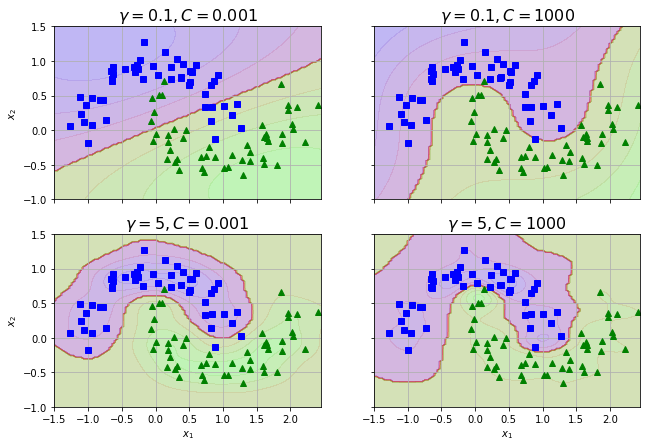

In [22]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

* Un $\gamma$ mayor reduce el ancho de la curva gaussiana, reduciendo la influencia de cada instancia $\rightarrow$ el límite de decisión será más irregular y adaptado a las posiciones de las instancias (riesgo de *overfitting*!)
* Un $\gamma$ menor tiene el efecto opuesto.

$\gamma$ actua como un parámetro de regularización (similar al parámetro `C`).

Hay otros *kernels* (menos usados), por ejemplo *string kernels* usados en clasificación de textos o secuencias de ADN.

#### Complejidad computacional

La clase `LinearSVC` está basada en la librería `liblinear` que implementa un algoritmo optimizado para SVMs lineales ([paper](https://www.csie.ntu.edu.tw/~cjlin/papers/cddual.pdf)).

Este algoritmo no permite el truco del *kernel* pero escala linealmente con el número de instancias de entrenamiento y *features*: $\mathcal{O}(m \times n)$.

Se puede aumentar la precisión con el hiperparámetro $\epsilon$ (llamado `tol` en Scikit-Learn).

La clase `SVC` está basada en la librería `libsvm` que implementa un algoritmo que funciona con el truco del *kernel* ([wikipedia](https://en.wikipedia.org/wiki/Sequential_minimal_optimization)).

El tiempo de entrenamiento escala entre $\mathcal{O}(m^2 \times n)$ y $\mathcal{O}(m^3 \times n)$.

Por lo tanto, es muy lento con muchas instancias de entrenamiento.

![](figures_svm/table5-1.png)

### Regresión SVM

Se puede invertir la meta del algoritmo: ajustar la "calle" para tener la mayoría de las instancias en la "calle" y limitar violaciones de margen (instancias fuera de la "calle").

El ancho de la calle está controlado por $\epsilon$.

![](figures_svm/fig5-10.png)

Agregando más instancias dentro del margen no afecta las predicciones del modelo.

In [24]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()


from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

(0.0, 2.0, 3.0, 11.0)

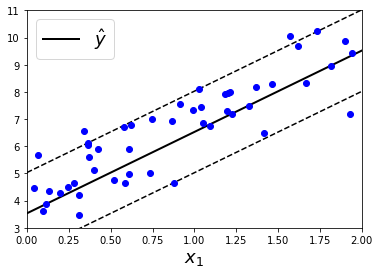

In [25]:
axes = [0,2,3,11]
x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
y_pred = svm_reg.predict(x1s)
plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
plot(x1s, y_pred + svm_reg.epsilon, "k--")
plot(x1s, y_pred - svm_reg.epsilon, "k--")
plot(X, y, "bo")
xlabel(r"$x_1$", fontsize=18)
legend(loc="upper left", fontsize=18)
axis(axes)

Para regresión no-lineal se puede usar un *kernel* de nuevo.

In [26]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [27]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

(-1.0, 1.0, 0.0, 1.0)

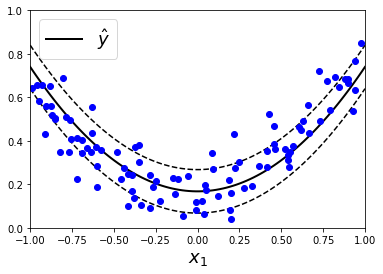

In [29]:
axes = [-1,1,0,1]
x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
y_pred = svm_poly_reg.predict(x1s)
plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
plot(x1s, y_pred + svm_poly_reg.epsilon, "k--")
plot(x1s, y_pred - svm_poly_reg.epsilon, "k--")
plot(X, y, "bo")
xlabel(r"$x_1$", fontsize=18)
legend(loc="upper left", fontsize=18)
axis(axes)

| ![](figures_svm/fig5-11.png) |
|------------------------------|
| Ejemplo del libro. Hay más regularización en el gráfico a la derecha. |

## Los detalles del método

* El término del *bias* es $b$.
* El vector de pesos de los *features* es $\boldsymbol{w}$ (antes usabamos $\boldsymbol{\theta}$).
* Ahora **no** hay un *feature* $x_0 = 1$ que corresponde al *bias*.

### Función de decisión y predicciones

La función de decisión del modelo es

$$h = \boldsymbol{w}^T \boldsymbol{x} + b$$

El clasificador de SVM lineal predice la clase de una instancia en la siguiente manera:

$$\hat{y} = \begin{cases} 0 & \boldsymbol{w}^T \boldsymbol{x} + b < 0 \\ 1 & \boldsymbol{w}^T \boldsymbol{x} + b \geq 0 \end{cases}$$

Volvemos al ejemplo de los datos de "Iris"

![](figures_svm/fig5-4-half.png)

![](figures_svm/fig5-12.png)

En este caso la función de decisión corresponde a un plano bidimensional (hay 2 *features*).

El límite de decisión es la intersección entre el plano de datos y el plano definido por $h$.

El margen está definido por las líneas donde $h = \pm 1$.

Entrenamiento de un modelo SVM lineal: encontrar los valores de $\boldsymbol{w}$ y $b$ tal que el margen sea lo más ancho posible, sin violaciones (margen duro) o con pocas violaciones (margen blando).

##### Más features

Con $n$ *features*, la función de decisión define un hiperplano de $n$ dimensiones, y el límite de decisión es un hiperplano de $(n-1)$ dimensiones.

### Objetivo del entrenamiento

La pendiente del plano definido por la función de decisión está dada por $||\boldsymbol{w}||$.

Si dividimos la pendiente por $2$, el margen será más ancho.

| ![](figures_svm/fig5-13.png) |
|------------------------------|
| Ejemplo con solamente $1$ *feature* |

Queremos minimizar $||\boldsymbol{w}||$ para obtener un margen amplio.

Pero si aplicamos un margen duro, queremos evitar cualquier violación del margen. Entonces necesitamos

$$h(\boldsymbol{x}_i) \begin{cases} > 1 & y^{(i)} = 1 \\ < -1 & y^{(i)} = 0 \end{cases}$$

Primero, definimos:

$$t^{(i)} = \begin{cases} +1 & y^{(i)} = 1 \\ -1 & y^{(i)} = 0 \end{cases}$$

Ahora podemos expresar nuestra restricción como

$$t^{(i)}(\boldsymbol{w}^T \boldsymbol{x}^{(i)} + b) \geq 1$$

para todas las instancias.

##### Entrenamiento con margen duro

Por lo tanto, el entrenamiento del clasificador SVM lineal (margen duro) corresponde al siguiente problema de **optimización restringida**:

$$\underset{\boldsymbol{w},b}{\text{minimizar}} \;\; \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} \;\; \text{sujeto a} \;\; t^{(i)}(\boldsymbol{w}^T \boldsymbol{x}^{(i)} + b) \geq 1 \;\; \text{para} \; i=1,\ldots,m$$

Usamos $\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} = \frac{1}{2}||\boldsymbol{w}||^2$ en vez de $||\boldsymbol{w}||$ porque es diferenciable en $\boldsymbol{w} = 0$.

##### Entrenamiento con margen blando

En el caso de un margen blando, introducimos una variable "floja" (*slack variable*) para cada instancia.

$\zeta^{(i)}$ es una medida de la violación del margen permitida para la instancia $i$.

Ahora tenemos dos objetivos en conflicto: reducir $\zeta^{(i)}$ para reducir violaciones del margen, y reducir $\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}$ para aumentar el margen.

Con el hiperparámetro $C$ se puede definir la importancia relativa de estos dos objetivos.

$$\underset{\boldsymbol{w},b,\zeta}{\text{minimizar}} \;\; \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} + C\sum_{i=1}^m \zeta^{(i)} \;\; \text{sujeto a} \;\; t^{(i)}(\boldsymbol{w}^T \boldsymbol{x}^{(i)} + b) \geq 1 - \zeta^{(i)} \; y \; \zeta^{(i)} \geq 0 \; \text{para} \; i=1,\ldots,m$$

#### Optimización cuadrática (*quadratic programming*)

Los problemas de optimización del margen duro y blando son problemas **convexos cuadráticos con restricciones lineales**.

Tales problemas se llaman problemas de optimización cuadrática (*quadratic programming*, QP).

Hay muchos métodos disponibles para resolver problemas así. La formulación general del problema es:

$$\underset{\boldsymbol{p}}{\text{minimizar}} \;\; \frac{1}{2}\boldsymbol{p}^T \boldsymbol{H} \boldsymbol{p} + \boldsymbol{f}^T\boldsymbol{p} \;\; \text{sujeto a} \;\; \boldsymbol{A}\boldsymbol{p} \leq \boldsymbol{b}$$

donde:

* $\boldsymbol{p}$ es un vector de dimensión $n_p$.
* $\boldsymbol{H}$ es una matriz de dimensión $n_p \times n_p$.
* $\boldsymbol{f}$ es un vector de dimensión $n_p$.
* $\boldsymbol{A}$ es una matriz de dimensión $n_c \times n_p$ ($n_c = $ número de restricciones)
* $\boldsymbol{b}$ es un vector de dimensión $n_c$.

La expresión $\boldsymbol{A}\boldsymbol{p} \leq \boldsymbol{b}$ define $n_c$ restricciones.

Se puede traducir esta formulación del problema a lo que vimos para el clasificador SVM lineal con margen duro:

* $n_p = n + 1$, donde $n$ es el número de *features* ($+1$ para el *bias*).
* $n_c = m$, donde $m$ es el número de instancias de entrenamiento.
* $\boldsymbol{H}$ es la matriz de identidad con $0$ en el elemento $(0,0)$ (para eliminar el término del *bias*).
* $\boldsymbol{f} = \boldsymbol{0}$
* $\boldsymbol{b} = \boldsymbol{-1}$
* $\boldsymbol{a}^{(i)} = -t^{(i)} \dot{\boldsymbol{x}}^{(i)}$ donde $\dot{\boldsymbol{x}}^{(i)}$ es igual a $\boldsymbol{x}^{(i)}$ aparte del elemento $\dot{\boldsymbol{x}}_0 = 1$ (*bias*) y $\boldsymbol{a}^{(i)}$ es la $i$-esima fila de la matriz $\boldsymbol{A}$.

Así que se puede entrenar un clasificador de SVM (margen duro) con algún algoritmo para resolver el problema QP.

El vector resultante $\boldsymbol{p}$ contendrá el término del *bias* $b = p_0$ y los pesos de los *features* $w_i = p_i$ para $i = 1,\ldots,n$.

Se puede usar un *solver* de QP para el problema de margen blando.

### El problema dual

Dado un problema de optimización restringida (**problema primario**) se puede expresar un problema diferente pero relacionado que se llama el **problema dual**.

La solución al problema dual típicamente da un límite inferior a la solución del problema primario. 

En algunos casos especiales (función de objetivo es convexa, las restricciones son continuamente diferenciable y convexas) las soluciones de los problemas primario y dual coinciden.

SVM satisface estas condiciones, así que podemos trabajar con el problema dual:

$$\underset{\alpha}{\text{minimizar}} \;\; \frac{1}{2}\sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \boldsymbol{x}^{(i)T} \boldsymbol{x}^{(j)} - \sum_{i=1}^m \alpha^{(i)} \;\; \text{sujeto a} \;\; \alpha^{(i)} \geq 0 \;\; \text{para} \;\; i = 1,\ldots,m$$

Una vez que hemos encontrado el vector $\hat{\alpha}$ que minimiza esta ecuación (con un *solver* de QP) podemos calcular $\hat{\boldsymbol{w}}$ y $\hat{b}$ que minimizan el problema primal:

$$\hat{\boldsymbol{w}} = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \boldsymbol{x}^{(i)}$$

$$\hat{b} = \frac{1}{n_s} \sum_{i=1}^m \left( t^{(i)} - \hat{\boldsymbol{w}}^T \boldsymbol{x}^{(i)} \right)$$

Es más rápido resolver el problema dual cuando hay menos instancias de entrenamiento que *features*, es decir $m < n$.

Más importante, el problema dual permite el truco del *kernel* (*kernel trick*).

### SVM con *kernels*

Ejemplo: aplicar un polinomio de grado 2 a datos de entrenamiento bidimensionales para entrenar un clasificador SVM lineal en los datos transformados:

$$\phi(\boldsymbol{x}) = \phi \left( \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \right) = \begin{pmatrix} x_1^2 \\ \sqrt{2}x_1x_2 \\ x_2^2 \end{pmatrix}$$

¿Que pasa con el producto punto de los vectores transformados?

$$\begin{split} \phi(\boldsymbol{a})^T\phi(\boldsymbol{b}) &= \begin{pmatrix} a_1^2 \\ \sqrt{2}a_1a_2 \\ a_2^2 \end{pmatrix} \begin{pmatrix} b_1^2 \\ \sqrt{2}b_1b_2 \\ b_2^2 \end{pmatrix}  = a_1^2b_1^2 + 2a_1b_1a_2b_2 + a_2^2b_2^2 \\ &= (a_1b_1 + a_2b_2)^2 = \left( \begin{pmatrix} a_1 \\ a_2 \end{pmatrix}^T \begin{pmatrix} b_1 \\ b_2 \end{pmatrix} \right)^2 = \left( \boldsymbol{a}^T \boldsymbol{b} \right)^2 \end{split}$$

Aplicando la transformación $\phi$ a todas las instancias, tendremos, en el problema dual, el producto punto $\phi(\boldsymbol{x}^{(i)})^T\phi(\boldsymbol{x}^{(j)})$.

Pero ahora sabemos que (en el caso del polinomio de grado 2) podemos reemplazar ese producto punto por $\left( x^{(i)T}x^{(j)} \right)^2$.

Así que, no hace falta aplicar la transformación $\phi$.

Esta es la esencia del truco del *kernel*: es mucho más eficiente computacionalmente.

La función $K(\boldsymbol{a},\boldsymbol{b}) = (\boldsymbol{a}^T \boldsymbol{b})^2$ se llama un *kernel* polinomial de grado 2.

Un *kernel* (en este contexto) es una función capaz de calcular el producto punto $\phi(\boldsymbol{a})^T \phi(\boldsymbol{b})$ usando solamente los vectores originales $\boldsymbol{a}$ y $\boldsymbol{b}$, sin saber nada de $\phi$.

*Kernels* comunes:

* Lineal: $K(\boldsymbol{a},\boldsymbol{b}) = \boldsymbol{a}^T \boldsymbol{b}$
* Polinomial: $K(\boldsymbol{a},\boldsymbol{b}) = \left( \gamma \boldsymbol{a}^T \boldsymbol{b} + r \right)^d$
* RBF gaussiana: $K(\boldsymbol{a},\boldsymbol{b}) =\exp \left( -\gamma || \boldsymbol{a} - \boldsymbol{b} ||^2 \right)$
* Sigmoide: $K(\boldsymbol{a},\boldsymbol{b}) = \tanh \left( \gamma \boldsymbol{a}^T \boldsymbol{b} + r \right)$

### Teorema de Mercer

Si una función $K(\boldsymbol{a},\boldsymbol{b})$ respeta algunas condiciones llamadas **condiciones de Mercer** (continua, simetrica en sus argumentos, etc.) entonces existe una función $\phi$ que mapea los vectores $\boldsymbol{a}$ y $\boldsymbol{b}$ a otro espacio tal que $K(\boldsymbol{a},\boldsymbol{b}) = \phi(\boldsymbol{a})^T \phi(\boldsymbol{b})$.

En el caso del *kernel* RBF gaussiana, $\phi$ corresponde a un mapeo a un espacio de dimensión infinita...

##### Predicciones usando kernels

Usando un *kernel* quizás no podemos obtener $\hat{\boldsymbol{w}}$. Entonces, ¿cómo podemos realizar predicciones con el modelo?

$$\begin{split} h_{\hat{\boldsymbol{w}},\hat{b}} \left( \phi \left( \boldsymbol{x}^{(n)} \right) \right) &= \hat{\boldsymbol{w}}^T \phi(\boldsymbol{x}^{(n)}) + \hat{b} = \left( \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \phi(\boldsymbol{x}^{(i)} \right) \phi(\boldsymbol{x}^{(n)}) + \hat{b} \\ &= \sum_{i=1}^m \hat{\alpha}^{(i)}t^{(i)} \left( \phi(\boldsymbol{x}^{(i)})^T \phi(\boldsymbol{x}^{(n)}) \right) + \hat{b} \\ &= \underset{\hat{\alpha}^{(i)} > 0}{\sum_{i=1}^m} \hat{\alpha}^{(i)}t^{(i)}K(\boldsymbol{x}^{(i)},\boldsymbol{x}^{(n)}) + \hat{b} \end{split}$$

Notar que $\alpha^{(i)} \neq 0$ solamente para los vectores de soporte, así que las predicciones requiere el producto punto entre el vector de la nueva instancia $\boldsymbol{x}^{(n)}$ y los vectores de soporte.

El término del *bias* se puede conseguir por el mismo truco:

$$\begin{split} \hat{b} &= \frac{1}{n_s} \sum_{i=1}^m (t^{(i)} - \hat{\boldsymbol{w}}^T \phi(\boldsymbol{x}^{(i)})) = \frac{1}{n_s} \sum_{i=1}^m \left( t^{(i)} - \left( \sum_{j=1}^m \hat{\alpha}^{(j)}t^{(j)}\phi(\boldsymbol{x}^{(j)}) \right)^T \phi(\boldsymbol{x}^{(i)}) \right) \\ &= \frac{1}{n_s} \sum_{i=1}^m \left( t^{(i)} - \sum_{j=1}^m \hat{\alpha}^{(j)}t^{(j)}K(\boldsymbol{x}^{(i)},\boldsymbol{x}^{(j)}) \right) \end{split}$$

donde todas las sumas incluyen solamente valores del índice $i$ donde $\hat{\alpha}^{(i)} > 0$ (es decir, los vectores de soporte).

#### Online SVMs

Ahora veremos brevemente como se puede entrenar un clasificador de SVM en forma *online* (incremental).

Para SVM lineal, una opción es descenso por gradiente (con `SGDClassifier` por ejemplo) para minimizar la función de costo abajo (derivado del problema primario):

$$J(\boldsymbol{w},b) = \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} + C\sum_{i=1}^m \max \left( 0, 1-t^{(i)}(\boldsymbol{w}^T \boldsymbol{x}^{(i)} + b) \right)$$

* La primera suma empuje el modelo hacia un vector $\boldsymbol{w}$ pequeño (margen más amplio).
* La segunda suma calcula el total de todas las violaciones del margen. El valor para cada instancia es proporcional a la distancia entre la instancia y el lado correcto de la "calle".

##### Hinge Loss

La función $\max(0,1-t)$ se llama la función de *hinge loss*. No es diferenciable en $t=1$, pero se puede usar una **subderivada** en $t=1$ (cualquier valor entre $-1$ y $0$).

![](figures_svm/hinge_loss.png)

##### Online SVM con kernel

También es posible entrenar un modelo de SVM con kernel en forma incremental:

[Incremental and Decremental SVM Learning](https://proceedings.neurips.cc/paper/2000/file/155fa09596c7e18e50b58eb7e0c6ccb4-Paper.pdf)

[Fast Kernel Classifiers with Online and Active Learning](https://www.jmlr.org/papers/volume6/bordes05a/bordes05a.pdf)

Estos métodos están implementados en C++ y Matlab. Si hay muchos datos, podría ser mejor considerar una red neuronal.